# Solving the Heat Equation with TensorFlow

blabla

### Configure notebook

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Import code from src
sys.path.insert(0, '../src/')
from tools import fig_path

tf.keras.backend.set_floatx("float64")
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)

### pneuma 

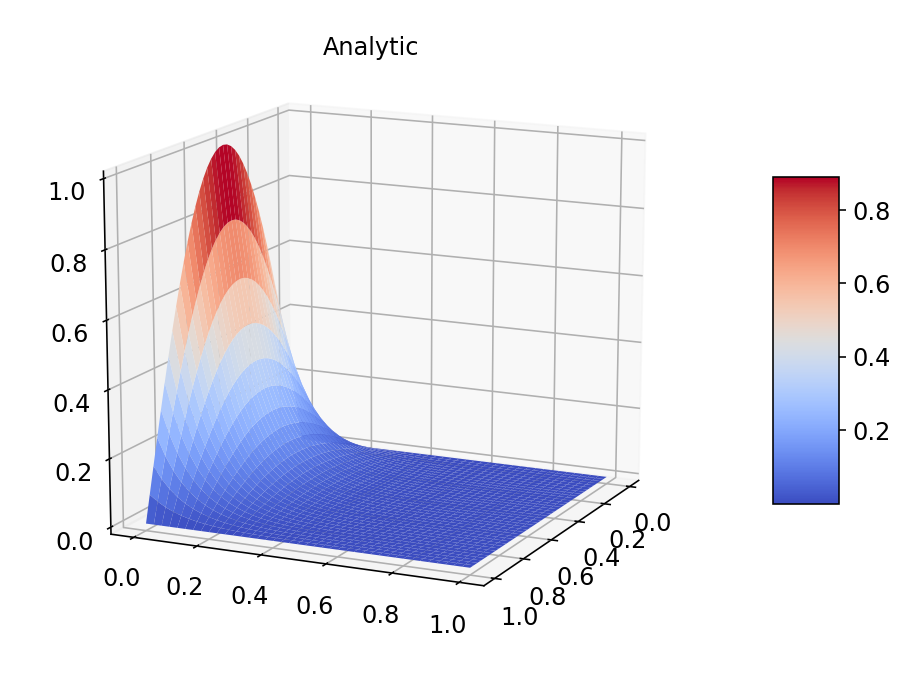

In [2]:
def g_analytic(x, t):
    """
    Analytic solution
    """

    return tf.sin(np.pi * x) * tf.exp(-np.pi**2 * t)

num_points = 41
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(1, dtype=tf.float64)
X, T = tf.meshgrid(tf.linspace(start, stop, num_points), tf.linspace(start, stop, num_points))
x, t = tf.reshape(X, [-1, 1]), tf.reshape(T, [-1, 1])
g = tf.reshape(g_analytic(x, t), (num_points, num_points))
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Analytic")
surf = ax.plot_surface(X, T, g, cmap=cm.coolwarm)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## First model

Step: 1, Loss: 10.019571553061562
Step: 100, Loss: 1.0373448207208333
Step: 200, Loss: 0.08944916846337161
Step: 300, Loss: 0.007327700926008949
Step: 400, Loss: 0.004599554720747042
Step: 500, Loss: 0.0027613916409925114
Step: 600, Loss: 0.002619885519155022
Step: 700, Loss: 0.0023025297150288475
Step: 800, Loss: 0.002106253444520594
Step: 900, Loss: 0.0017916721194943994
Step: 1000, Loss: 0.0016617125560005742
Max diff: 0.05224646323864751
Mean diff: 0.004334475145176679


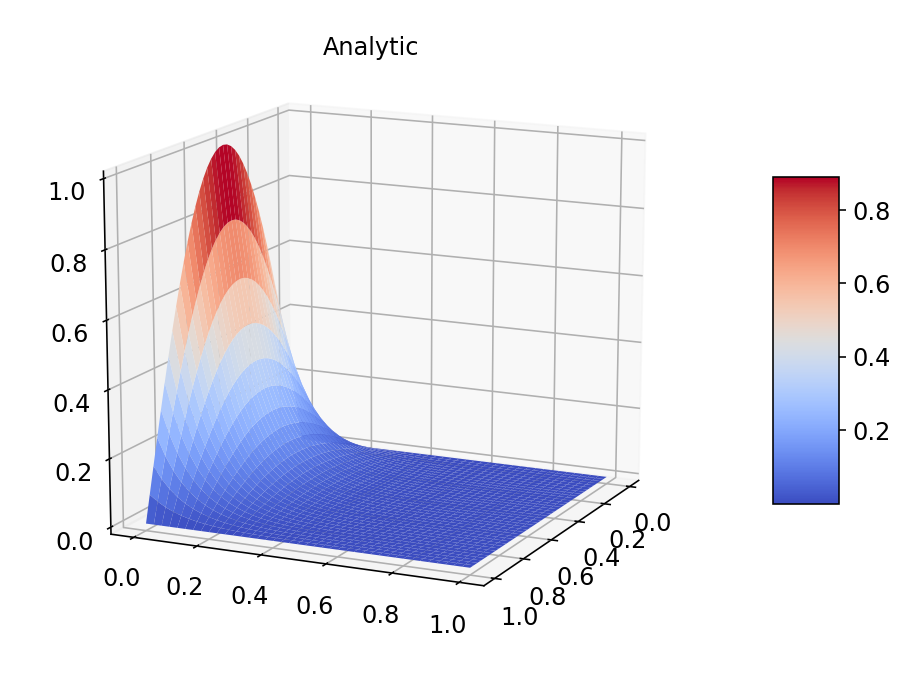

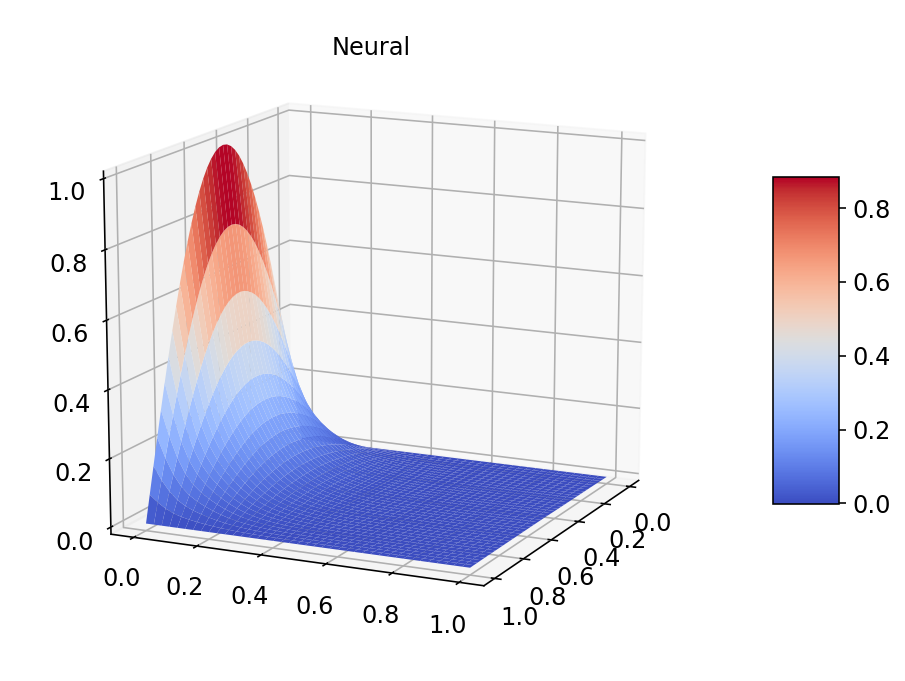

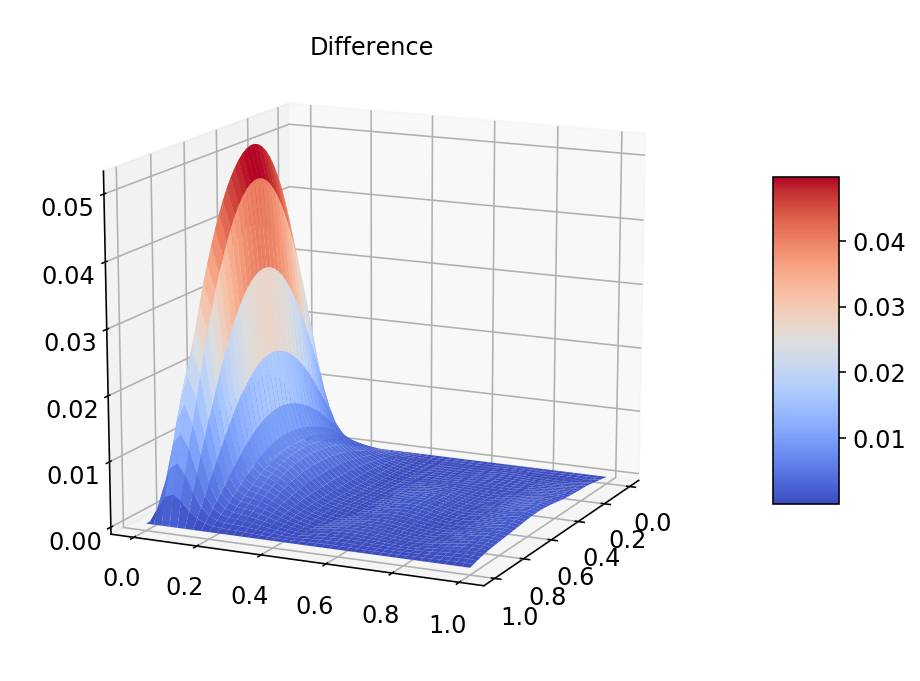

In [3]:
# Define grid
num_points = 11
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(1, dtype=tf.float64)
stop_t = stop

X, T = tf.meshgrid(tf.linspace(start, stop, num_points),
                   tf.linspace(start, stop_t, num_points))

x, t = tf.reshape(X, [-1, 1]), tf.reshape(T, [-1, 1])


class DNModel(tf.keras.Model):
    def __init__(self):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(150, activation=tf.nn.tanh)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(1, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)

        return self.out(x)


@tf.function
def IC(x):
    """
    Initial condition
    """

    return tf.sin(np.pi * x)


@tf.function
def trial_solution(model, x, t):
    """
    Trial solution
    """

    points = tf.concat([x, t], axis=1)

    return (1 - t) * IC(x) + x * (1 - x) * t * model(points)


@tf.function
def loss(model, x, t):
    """
    Loss/cost function
    """

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        with tf.GradientTape(persistent=True) as tape_2:
            tape_2.watch([x, t])

            trial = trial_solution(model, x, t)

        d_trial_dx = tape_2.gradient(trial, x)
        d_trial_dt = tape_2.gradient(trial, t)

    d2_trial_d2x = tape.gradient(d_trial_dx, x)

    del tape_2
    del tape

    return tf.losses.MSE(
        tf.zeros_like(d2_trial_d2x), d2_trial_d2x - d_trial_dt)


# Define gradient method
@tf.function
def grad(model, x, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, t)

    return loss_value, tape.gradient(loss_value, model.trainable_variables)


# Initial model and optimizer
model = DNModel()
optimizer = tf.keras.optimizers.Adam(0.01)


# Run training loop
num_epochs = 1000

for epoch in range(num_epochs):
    # Apply gradients in optimizer
    cost, gradients = grad(model, x, t)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Output loss improvement
    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")


# Plot solution on larger grid
num_points = 41
X, T = tf.meshgrid(
    tf.linspace(start, stop, num_points), tf.linspace(
        start, stop_t, num_points)
)
x, t = tf.reshape(X, [-1, 1]), tf.reshape(T, [-1, 1])

g = tf.reshape(g_analytic(x, t), (num_points, num_points))
g_nn = tf.reshape(trial_solution(model, x, t), (num_points, num_points))

diff = tf.abs(g - g_nn)
print(f"Max diff: {tf.reduce_max(diff)}")
print(f"Mean diff: {tf.reduce_mean(diff)}")

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Analytic")
surf = ax.plot_surface(X, T, g, cmap=cm.coolwarm)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_ana.pdf"), bbox_inches='tight')

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Neural")
surf = ax.plot_surface(X, T, g_nn, cmap=cm.coolwarm)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_nn1.pdf"), bbox_inches='tight')

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Difference")
surf = ax.plot_surface(X, T, diff, cmap=cm.coolwarm)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_diff_nn1.pdf"), bbox_inches='tight')

plt.show()   